In [1]:
!pip install --upgrade pytorch-pretrained-vit
!pip install torchsummary

  Created wheel for pytorch-pretrained-vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11131 sha256=229a1b9b38872faff07028df769719dfd0f9e0eacd033b5e39fb1d0468e91e52
  Stored in directory: /root/.cache/pip/wheels/87/1d/d1/c6852ef6d18565e5aee866432ab40c6ffbd3411d592035cddb
Successfully built pytorch-pretrained-vit


In [2]:
!apt -y install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams.update(plt.rcParamsDefault)

plt.matplotlib.rc('figure', figsize=(10, 6))
plt.matplotlib.rc('grid', linestyle = 'dotted', linewidth=1.5, alpha = 0.25)
plt.matplotlib.rc('text', usetex=True)
plt.matplotlib.rc('font', family='serif', size=15)
plt.matplotlib.rc('legend', fontsize=15)

# Change ticks
plt.rcParams['xtick.major.size'] = 7.0
plt.rcParams['xtick.minor.size'] = 4.0
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.major.size'] = 7.0
plt.rcParams['ytick.minor.size'] = 4.0
plt.rcParams['ytick.direction'] = 'inout'




The following additional packages will be installed:
  cm-super-minimal fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-extra
  fonts-ebgaramond fonts-ebgaramond-extra fonts-font-awesome
  fonts-freefont-otf fonts-freefont-ttf fonts-gfs-artemisia
  fonts-gfs-complutum fonts-gfs-didot fonts-gfs-neohellenic fonts-gfs-olga
  fonts-gfs-solomos fonts-go fonts-junicode fonts-lato fonts-linuxlibertine
  fonts-lobster fonts-lobstertwo fonts-noto-hinted fonts-noto-mono
  fonts-oflb-asana-math fonts-open-sans fonts-roboto-hinted fonts-sil-gentium
  fonts-sil-gentium-basic fonts-sil-gentiumplus fonts-sil-gentiumplus-compact
  fonts-stix fonts-texgyre ghostscript gsfonts pfb2t1c2pfb tex-gyre
  texlive-fonts-extra-links
Suggested packages:
  fontforge ghostscript-x texlive-fonts-extra-doc
  texlive-fonts-recommended-doc
The following NEW packages will be insta

In [3]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from pytorch_pretrained_vit import ViT

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

PATH = '../input/covidxct'
IMAGES_PATH = f'{PATH}/2A_images'

IMAGE_DIM = 384

CLASSES = {
    0: 'Normal', 
    1: 'Sick', 
}

# lock the seed
SEED = 211
np.random.seed(SEED)
torch.manual_seed(SEED)

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    
# create a folder to save the model
if not os.path.isdir('CHECKPOINTS'):
    os.mkdir('CHECKPOINTS')
    
    
def elapsed_time(start_time):
    # source: https://stackoverflow.com/a/27780763
    hours, rem = divmod(time.time() - start_time, 3600)
    minutes, seconds = divmod(rem, 60)
    duration = "{:0>2}:{:0>2}:{:02d}".format(int(hours), int(minutes), int(seconds))
    return duration

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


## Costum Dataloader

> **Based on:** https://medium.com/analytics-vidhya/creating-a-custom-dataset-and-dataloader-in-pytorch-76f210a1df5d

In [4]:
class CustomDataset(Dataset):
    def __init__(self, label_file:str, transform_img=False):
        self.label_file = label_file
        self.transform_img = transform_img
        fnames, classes, bboxes = self.load_labels()
        
        self.data = []
        self.positive_idxs = []
        self.negative_idxs = []
        for i in range(len(fnames)):
            self.data.append([f'{IMAGES_PATH}/{fnames[i]}', classes[i], bboxes[i]])
            if classes[i] == 0:
                self.negative_idxs.append(i)
            if classes[i] == 1:
                self.positive_idxs.append(i)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label, bbox = self.data[idx]
        
        class_id = torch.tensor([label])
        img = cv2.imread(img_path)
        
        # crop to fit in bounding box
        img = img[bbox[1]:bbox[3], bbox[0]:bbox[2], :]
        
        # resize to fit in model input
        img = cv2.resize(img, (IMAGE_DIM, IMAGE_DIM))
        
        #convert image to tensor
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1).float()
        
        if self.transform_img:
            img_transforms = transforms.Compose([
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            img_tensor = img_transforms(img_tensor)
        
        return img_tensor, class_id
    
    def load_labels(self):
        """Loads image filenames, classes, and bounding boxes"""
        fnames, classes, bboxes = [], [], []
        with open(self.label_file, 'r') as f:
            for line in f.readlines():
                fname, cls, xmin, ymin, xmax, ymax = line.strip('\n').split()
                cls = int(cls)
                if (cls == 0) | (cls == 2): # remove pneumania class
                    fnames.append(fname)
                    classes.append(0 if cls == 0 else 1)
                    bboxes.append((int(xmin), int(ymin), int(xmax), int(ymax)))
        return fnames, classes, bboxes
    

def get_dataloader(label_file, batch_size, shuffle=True, num_workers=1, max_images=-1, transform_img=False):
    """Returns a Dataloader object, which supports using only part of the data"""
    dataset = CustomDataset(label_file, transform_img)
    
    loader_settings = {
        'dataset': dataset,
        'batch_size': batch_size,
        'shuffle': shuffle,
        'num_workers': num_workers,
        'pin_memory': torch.cuda.is_available()
    }
    
    
    if 0 < max_images < len(dataset):        
        negative_idxs = dataset.negative_idxs
        positive_idxs = dataset.positive_idxs
        
        np.random.shuffle(negative_idxs)
        np.random.shuffle(positive_idxs)
        
        # don't use all the images in the dataset, equal parts positive and negative
        negative_idxs = negative_idxs[:int(max_images/2)]
        positive_idxs = positive_idxs[:int(max_images/2)]
        
        idxs = np.concatenate((positive_idxs, negative_idxs))
        np.random.shuffle(idxs)
        
        indices = torch.from_numpy(idxs)
        loader_settings['sampler'] = SubsetRandomSampler(indices)
        loader_settings['shuffle'] = False
        
    return DataLoader(**loader_settings)

## Review Dataset

> **Source:** https://www.kaggle.com/hgunraj/covidx-ct-starter-code

In [5]:
pd.read_csv('../input/covidxct/metadata.csv')

,patient id,source,country,sex,age,finding,verified finding,slice selection,view,modality
0,CP_0,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT
1,CP_10,CNCB,China,NaN,NaN,Pneumonia,Yes,Automatic,Axial,CT
2,CP_1068,CNCB,China,NaN,NaN,Pneumonia,Yes,Automatic,Axial,CT
3,CP_1070,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT
4,CP_1071,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT
...,...,...,...,...,...,...,...,...,...,...
4496,HUST-Patient93,iCTCF,China,M,69.0,COVID-19,Yes,Automatic,Axial,CT
4497,HUST-Patient94,iCTCF,China,F,30.0,COVID-19,Yes,Automatic,Axial,CT
4498,HUST-Patient95,iCTCF,China,M,64.0,COVID-19,Yes,Automatic,Axial,CT
4499,HUST-Patient96,iCTCF,China,M,32.0,COVID-19,Yes,Automatic,Axial,CT


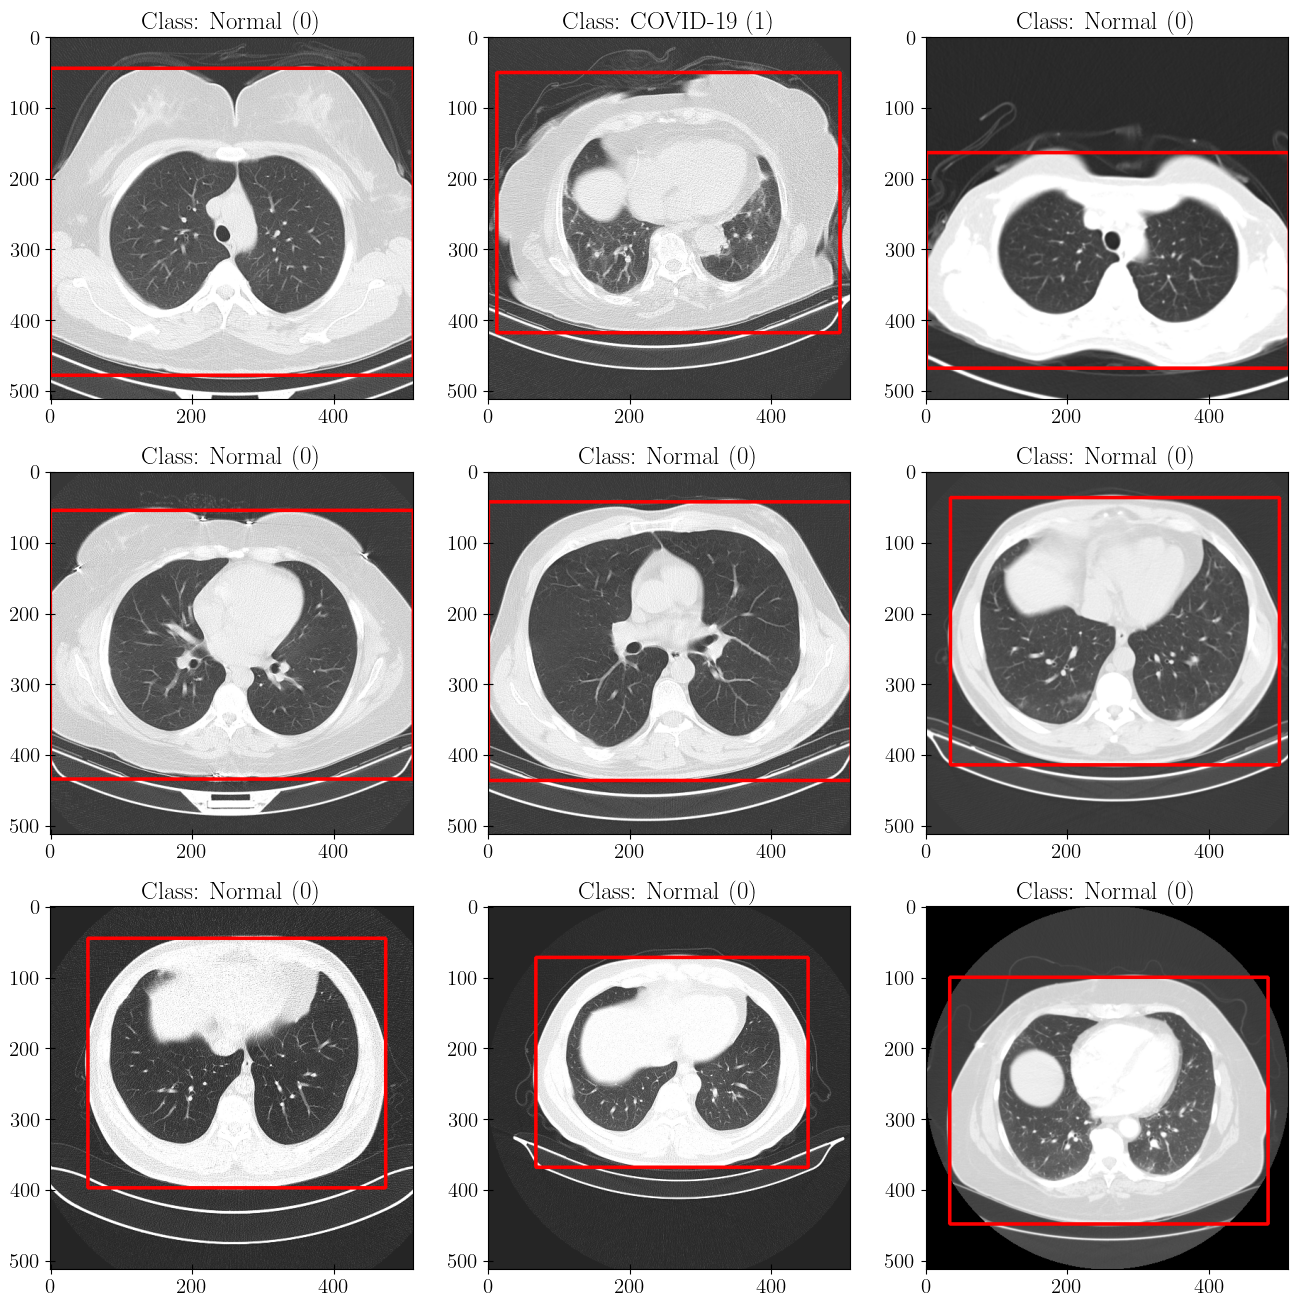



Preprocessing:


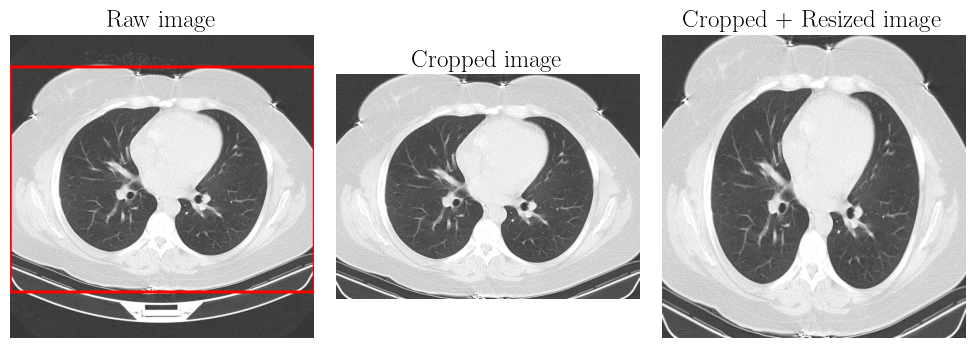

In [6]:
# Set paths
image_dir = '/kaggle/input/covidxct/2A_images'
label_file = '/kaggle/input/covidxct/val_COVIDx_CT-2A.txt'

# Load labels
fnames, classes, bboxes = CustomDataset(label_file).load_labels()

#####################################################################
#                        Preview Some Images
#####################################################################

# Select cases to view
indices = np.random.choice(list(range(len(fnames))), 9)

# Show a grid of 9 images
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
class_names = ('Normal', 'COVID-19')
for index, ax in zip(indices, axes.ravel()):
    # Load the CT image
    image_file = os.path.join(image_dir, fnames[index])
    image = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)

    # Overlay the bounding box
    image = np.stack([image]*3, axis=-1)  # make image 3-channel
    bbox = bboxes[index]
    cv2.rectangle(image, bbox[:2], bbox[2:], color=(255, 0, 0), thickness=3)

    # Display
    cls = classes[index]
    ax.imshow(image)
    ax.set_title('Class: {} ({})'.format(class_names[cls], cls))
plt.savefig('example.png', dpi=300)
plt.show()

#####################################################################
#                      Preview the Preprocessing
#####################################################################
print('\n\nPreprocessing:')

index = indices[3]

# Load the CT image
image_file = os.path.join(image_dir, fnames[index])
image = cv2.imread(image_file)

# Overlay the bounding box
bbox = bboxes[index]
image_with_bb = np.copy(image)
cv2.rectangle(image_with_bb, bbox[:2], bbox[2:], color=(255, 0, 0), thickness=3)

# crop
image = image[::,::,::-1]
bbox #xmin ymin xmax ymax
cropped_im = image[bbox[1]:bbox[3], bbox[0]:bbox[2], :]

# resize
dim = (384, 384)
resized_im = cv2.resize(cropped_im, dim, interpolation=cv2.INTER_AREA)

plt.figure(figsize=(10, 4), dpi=100)

plt.subplot(1,3,1)
plt.imshow(image_with_bb)
plt.axis('off')
plt.title('Raw image')

plt.subplot(1,3,2)
plt.imshow(cropped_im)
plt.axis('off')
plt.title('Cropped image')

plt.subplot(1,3,3)
plt.imshow(resized_im)
plt.axis('off')
plt.title('Cropped + Resized image')

plt.tight_layout()
plt.savefig('preprocessing.png', dpi=300)
plt.show()

Batch of images has shape: torch.Size([4, 3, 384, 384])
Batch of labels has shape: torch.Size([4, 1])


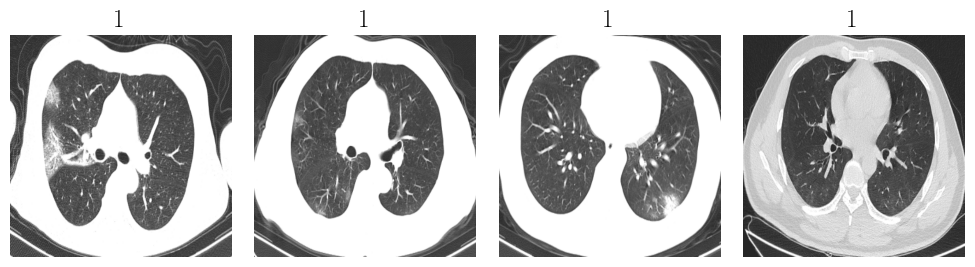

In [7]:
def preview_dataset(plot_batch_size=4):
    plot_label_file = f'{PATH}/train_COVIDx_CT-2A.txt'
    plot_dataset = CustomDataset(plot_label_file)
    plot_dataloader = DataLoader(
        plot_dataset, batch_size=plot_batch_size, shuffle=True
    )

    plt.figure(figsize=(10,3), dpi=100)

    for imgs, labels in plot_dataloader:
        print(f"Batch of images has shape: {imgs.shape}")
        print(f"Batch of labels has shape: {labels.shape}")
        for i in range(len(imgs)):
            plt.subplot(1, plot_batch_size, i+1)
            img = imgs[i].permute(1, 2, 0)
            img = img.numpy().astype(np.uint8)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'{labels[i].numpy()[0]}')
        break

    plt.tight_layout()
    plt.show()
    
preview_dataset()

## Pretrained Vision Transformer

> **Source:** https://github.com/lukemelas/PyTorch-Pretrained-ViT

In [8]:
class PretrainedViT:
    def __init__(self, model_name='B_16_imagenet1k'):
        self.model = ViT(model_name, pretrained=True)
        self.freeze_all_layers()

    def freeze_all_layers(self):
        """Freeze the model so it's won't change the pretrained whights"""
        for key, module in self.model._modules.items():
            for param in module.parameters():
                param.requires_grad = False

    def unfreeze_fully_connected(self):
        """Unfreeze the whights of the last fully connected layer"""
        self.model.fc.weight.requires_grad = True
        self.model.fc.bias.requires_grad = True

    def replace_fully_connected(self, block):
        """Replace the last fully connected layer with a given block"""
        self.model.fc = block


## Training Model

In [9]:
############################################################
#                    Initialize the Model
############################################################
vit = PretrainedViT()
vit.unfreeze_fully_connected()

# the original model have 1000 classes. Here only 1 are needed so 
# the shape of the last fully-connected layer need to change.
vit.replace_fully_connected(
    nn.Sequential(
        nn.Linear(vit.model.fc.in_features, 2048),
        nn.ReLU(inplace=True),
        nn.Linear(2048, 1),
        nn.Sigmoid()
    )
)

model = vit.model.to(device)
model_name = 'pretrained_ViT'

summary(model, (3, IMAGE_DIM, IMAGE_DIM))

Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth" to /root/.cache/torch/hub/checkpoints/B_16_imagenet1k.pth


  0%|          | 0.00/331M [00:00<?, ?B/s]

Loaded pretrained weights.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 24, 24]         590,592
PositionalEmbedding1D-2             [-1, 577, 768]               0
         LayerNorm-3             [-1, 577, 768]           1,536
            Linear-4             [-1, 577, 768]         590,592
            Linear-5             [-1, 577, 768]         590,592
            Linear-6             [-1, 577, 768]         590,592
           Dropout-7         [-1, 12, 577, 577]               0
MultiHeadedSelfAttention-8             [-1, 577, 768]               0
            Linear-9             [-1, 577, 768]         590,592
          Dropout-10             [-1, 577, 768]               0
        LayerNorm-11             [-1, 577, 768]           1,536
           Linear-12            [-1, 577, 3072]       2,362,368
           Linear-13             [-1, 577, 768]       2,360,064
Pos

In [10]:
def performance_metrics(model, dataloader):
    predictions, true_labels = [], []
    with torch.no_grad():
        for data in tqdm(dataloader, leave=False):
            val_images, val_labels = data

            val_images = val_images.to(device).to(torch.float32)
            val_labels = val_labels.to(device).to(torch.float32)

            y_pred = model(val_images)
            y_true = val_labels

            predictions += list((y_pred > 0.5).to(torch.int32).squeeze().cpu().numpy())
            true_labels += list(y_true.squeeze().to(torch.int32).cpu().numpy())

    N = len(true_labels)
    true = np.array(predictions) == np.array(true_labels)
    false = np.array(predictions) != np.array(true_labels)
    positive = np.array(predictions) > 0.5
    negative = np.array(predictions) < 0.5
    tn = 100 * np.sum(true * negative) / N
    tp = 100 * np.sum(true * positive) / N
    fn = 100 * np.sum(false * negative) / N
    fp = 100 * np.sum(false * positive) / N
    accuracy = np.sum(true) / N
    
    return tn, tp, fn, fp, accuracy

In [11]:
############################################################
#                      Dataloaders
############################################################

batch_size = 4

train_label_file = f'{PATH}/train_COVIDx_CT-2A.txt'
train_dataloader = get_dataloader(label_file=train_label_file, 
                                  batch_size=batch_size,
                                  max_images=10000)
    
val_label_file = f'{PATH}/val_COVIDx_CT-2A.txt'
val_dataloader = get_dataloader(label_file=val_label_file, 
                                batch_size=batch_size,
                                max_images=10000)

test_label_file = f'{PATH}/test_COVIDx_CT-2A.txt'
test_dataloader = get_dataloader(label_file=test_label_file, 
                                 batch_size=batch_size,
                                 max_images=10000)

In [12]:
############################################################
#                      Hyperparametrs
############################################################
epochs = 3

learning_rate = 2e-3

# select loss
criterion = nn.BCELoss()

# select optimizer
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=learning_rate,
    amsgrad=True
)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.8)

In [13]:
start_time = time.time()
epochs_log = []

for epoch in range(1, epochs+1):
    running_loss = 0.0
    epoch_time = time.time()

    with tqdm(train_dataloader, unit="batch", leave=False) as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"{elapsed_time(start_time)} | Epoch {epoch:02d}/{epochs}")
            
            images = images.to(device).to(torch.float32)
            labels = labels.to(device).to(torch.float32).squeeze()
            
            pred = model(images).squeeze()       # forward pass
            loss = criterion(pred, labels)       # calculate the loss
            optimizer.zero_grad()                # zero the parameter gradients
            loss.backward()                      # backpropagation
            optimizer.step()                     # update parameters

            running_loss += loss.data.item()
        
        # update learning rate
        curr_lr = scheduler.get_last_lr()
        scheduler.step()                         
        
        # calculate loss and accuracy
        running_loss /= len(train_dataloader)

        tn, tp, fn, fp, accuracy = performance_metrics(model, val_dataloader)

        # show results to tqdm
        tepoch.refresh()
        tepoch.set_description(f"{elapsed_time(start_time)} | Epoch {epoch:02d}/{epochs}")
        
        epoch_results = [
            f'{elapsed_time(start_time)}',
            f'Epoch {epoch:02d}/{epochs}',
            f'lr: {curr_lr[0]:.1e}',
            f'Loss: {running_loss:.3f}',
            f'Validation  -  accuracy: {100*accuracy:.02f}%,  tp: {tp:2.01f}%,  tn: {tn:.01f}%,  fp: {fp:.01f}%,  fn: {fn:.01f}%'
        ]
        epochs_log.append(epoch_results)
        print(*epoch_results, sep=' | ')

  0%|          | 0/2500 [00:00<?, ?batch/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

00:14:03 | Epoch 01/3 | lr: 2.0e-03 | Loss: 0.566 | Validation  -  accuracy: 68.44%,  tp: 27.9%,  tn: 40.5%,  fp: 9.5%,  fn: 22.1%


  0%|          | 0/2500 [00:00<?, ?batch/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

00:28:07 | Epoch 02/3 | lr: 1.6e-03 | Loss: 0.477 | Validation  -  accuracy: 73.44%,  tp: 34.4%,  tn: 39.1%,  fp: 10.9%,  fn: 15.6%


  0%|          | 0/2500 [00:00<?, ?batch/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

00:42:11 | Epoch 03/3 | lr: 1.3e-03 | Loss: 0.452 | Validation  -  accuracy: 75.32%,  tp: 41.2%,  tn: 34.1%,  fp: 15.9%,  fn: 8.8%


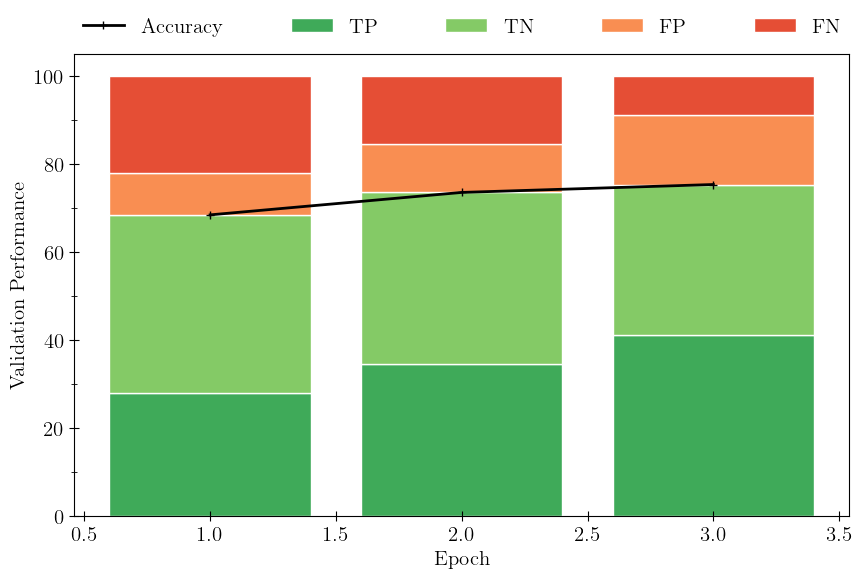

In [14]:
tp = [float(i[-1].split('tp: ')[1].split(' ')[0].replace('%,', '')) for i in epochs_log]
tn = [float(i[-1].split('tn: ')[1].split(' ')[0].replace('%,', '')) for i in epochs_log]
fp = [float(i[-1].split('fp: ')[1].split(' ')[0].replace('%,', '')) for i in epochs_log]
fn = [float(i[-1].split('fn: ')[1].split(' ')[0].replace('%' , '')) for i in epochs_log]

A = np.array(tp)
B = np.array(tn)
C = np.array(fp)
D = np.array(fn)

Total = A + B + C + D

norm_A = A / Total * 100
norm_B = B / Total * 100
norm_C = C / Total * 100
norm_D = D / Total * 100

Pos = range(1, epochs+1)

colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, 8))
        

# plt.figure(figsize=(8,5), dpi=100)
fig, ax = plt.subplots()

plt.bar(Pos, norm_A, color=colors[7], edgecolor='white', label='TP')
plt.bar(Pos, norm_B, bottom = norm_A, color=colors[6], edgecolor='white', label='TN')
plt.bar(Pos, norm_C, bottom = norm_A + norm_B, color=colors[1], edgecolor='white', label='FP')
plt.bar(Pos, norm_D, bottom = norm_A + norm_B + norm_C, color=colors[0], edgecolor='white', label='FN')
plt.plot(Pos, norm_A+norm_B, color='black', label='Accuracy', marker='+', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Validation Performance')
ax.yaxis.set_minor_locator(MultipleLocator(10))   # select minor ticks on y axis
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=5, mode="expand", borderaxespad=0., frameon=False)
     
plt.savefig('results.png', dpi=300)
plt.show()

In [15]:
test_label_file = f'{PATH}/test_COVIDx_CT-2A.txt'
test_dataloader = get_dataloader(label_file=test_label_file, 
                                 batch_size=batch_size,
                                 max_images=5000)

tn, tp, fn, fp, accuracy = performance_metrics(model, test_dataloader)
print(f'Test  -  accuracy: {100*0.7816:.02f}%,  tp: {39.54:2.01f}%,  tn: {38.62:.01f}%,  fp: {11.38:.01f}%,  fn: {10.46:.01f}%')

  0%|          | 0/1250 [00:00<?, ?it/s]

Test  -  accuracy: 78.16%,  tp: 39.5%,  tn: 38.6%,  fp: 11.4%,  fn: 10.5%


## Extract Features

### VGG Features

In [16]:
############################################################
#                    Initialize the Model
############################################################
model = models.vgg16(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Identity()

############################################################
#                   Initialize the Dataset
############################################################
train_label_file = f'{PATH}/train_COVIDx_CT-2A.txt'
train_dataloader = get_dataloader(label_file=train_label_file, 
                                  batch_size=1,
                                  max_images=60000,
                                  transform_img=True)

val_label_file = f'{PATH}/val_COVIDx_CT-2A.txt'
val_dataloader = get_dataloader(label_file=val_label_file, 
                                batch_size=batch_size,
                                max_images=10000,
                                transform_img=True)

############################################################
#                     Extract Features
############################################################
predictions = np.zeros((10000, num_features))
true_values = np.zeros((10000, 1))

with torch.no_grad():
    for i, data in enumerate(tqdm(val_dataloader)):
        images, labels = data

        images = images.to(torch.float32)
        labels = labels.to(torch.float32)

        y_pred = model(images.to(device)).squeeze().cpu().numpy()
        y_true = labels.to(device).squeeze().cpu().data.item()
        
        predictions[i] = y_pred
        true_values[i] = y_true

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

ValueError: only one element tensors can be converted to Python scalars

### ViT Features

In [17]:
############################################################
#                    Initialize the Model
############################################################
num_features = 768
vit = PretrainedViT()
vit.replace_fully_connected(nn.Identity())
model = vit.model.to(device)

############################################################
#                   Initialize the Dataset
############################################################
train_label_file = f'{PATH}/train_COVIDx_CT-2A.txt'
train_dataloader = get_dataloader(label_file=train_label_file, 
                                  batch_size=1,
                                  max_images=60000)

val_label_file = f'{PATH}/val_COVIDx_CT-2A.txt'
val_dataloader = get_dataloader(label_file=val_label_file, 
                                batch_size=batch_size,
                                max_images=10000)

############################################################
#                     Extract Features
############################################################
predictions = np.zeros((10000, num_features))
true_values = np.zeros((10000, 1))

with torch.no_grad():
    for i, data in enumerate(tqdm(val_dataloader)):
        images, labels = data

        images = images.to(torch.float32)
        labels = labels.to(torch.float32)

        y_pred = model(images.to(device)).squeeze().cpu().numpy()
        y_true = labels.to(device).squeeze().cpu().data.item()
        
        predictions[i] = y_pred
        true_values[i] = y_true

Loaded pretrained weights.


  0%|          | 0/2500 [00:00<?, ?it/s]

ValueError: only one element tensors can be converted to Python scalars

> Save Features:

In [18]:
pd.DataFrame(predictions).to_csv("val_predictions_vgg.csv", header=None, index=None)
pd.DataFrame(true_values).to_csv("val_true_values_vgg.csv", header=None, index=None)